<a href="https://colab.research.google.com/github/hongjumeow/GCT634/blob/main/GCT634_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Musical Instrument Recognition  (Single-Label Classification)

# Importing Packages

In [ ]:
# load libraries
import sys
import os
import numpy as np
import librosa
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

# Global Settings


In [582]:

# Change this data path with your own local path
data_path = './gct634_nsynth/'

# path to store MFCC
mfcc_path = './nsynth_features/mfcc/'

MFCC_DIM = 15

NUM_TRAIN = 1100 # 1100
NUM_VALID = 300 # 300


# Feature Extraction

In [583]:
def extract_mfcc(dataset='train'):
    f = open(data_path + dataset + '_list.txt','r')

    i = 0
    for file_name in f:
        # progress check
        i = i + 1
        if not (i % 10):
            if dataset == 'train':
              print("\r {:.2f}%".format(i/NUM_TRAIN*100), end='')
            elif dataset == 'valid':
              print("\r {:.2f}%".format(i/NUM_VALID*100), end='')

        # load audio file
        file_name = file_name.rstrip('\n')
        file_path = data_path + file_name
        y, sr = librosa.load(file_path, sr=22050)

        ##### Method 1
        # mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=MFCC_DIM)

        ##### Method 2
        
        # STFT
        S = librosa.core.stft(y, n_fft=1024, hop_length=512, win_length=1024)

        # power spectrum
        D = np.abs(S)**2

        # mel spectrogram (512 --> 40)
        mel_basis = librosa.filters.mel(sr=sr, n_fft=1024, n_mels=40)
        mel_S = np.dot(mel_basis, D)

        #log compression
        log_mel_S = librosa.power_to_db(mel_S)

        # mfcc (DCT)
        mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=MFCC_DIM)

        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2) # add delta
        
        spectral_centroid = np.repeat(librosa.feature.spectral_centroid(S=np.sqrt(D), sr=sr), 1, axis=0)
        spectral_bandwidth = np.repeat(librosa.feature.spectral_bandwidth(S=np.sqrt(D), sr=sr), 1, axis=0)
        spectral_flatness = np.repeat(librosa.feature.spectral_flatness(S=np.sqrt(D)), 1, axis=0)

        rms = np.repeat(librosa.feature.rms(y=y, frame_length=1024, hop_length=512), 1, axis=0)  # shape: (1, time_frames)
        
        mfcc = mfcc.astype(np.float32)    # to save the memory (64 to 32 bits)
        delta_mfcc = delta_mfcc.astype(np.float32)    # to save the memory (64 to 32 bits)
        delta2_mfcc = delta2_mfcc.astype(np.float32)    # to save the memory (64 to 32 bits)
        spectral_centroid = spectral_centroid.astype(np.float32)    # to save the memory (64 to 32 bits)
        spectral_bandwidth = spectral_bandwidth.astype(np.float32)    # to save the memory (64 to 32 bits)
        spectral_flatness = spectral_flatness.astype(np.float32)    # to save the memory (64 to 32 bits)
        rms = rms.astype(np.float32)

        mfcc = np.vstack([
          mfcc,
          delta_mfcc, delta2_mfcc, 
          spectral_centroid,
          spectral_bandwidth,
          spectral_flatness,
          rms,
          ])

        # save mfcc as a file
        file_name = file_name.replace('.wav','.npy')
        save_file = mfcc_path + file_name

        if not os.path.exists(os.path.dirname(save_file)):
            os.makedirs(os.path.dirname(save_file))
        np.save(save_file, mfcc)

    f.close()

In [584]:
extract_mfcc(dataset='train')
extract_mfcc(dataset='valid')

 100.00%

# Feature Summary

In [585]:
def mean_mfcc(dataset='train'):

    f = open(data_path + dataset + '_list.txt','r')

    if dataset == 'train':
        mfcc_mat = np.zeros(shape=(3*MFCC_DIM + 1*4, NUM_TRAIN))
    elif dataset == 'valid':
        mfcc_mat = np.zeros(shape=(3*MFCC_DIM + 1*4, NUM_VALID))

    i = 0
    for file_name in f:

        # load mfcc file
        file_name = file_name.rstrip('\n')
        file_name = file_name.replace('.wav','.npy')
        mfcc_file = mfcc_path + file_name
        mfcc = np.load(mfcc_file)

        # mean pooling
        temp = np.mean(mfcc, axis=1) # (20,)
        mfcc_mat[:, i]= np.mean(mfcc, axis=1) # 2개 단계의 MFCC를 평균?
        i = i + 1

    f.close()

    return mfcc_mat


In [586]:
train_mfcc = mean_mfcc('train')
valid_mfcc = mean_mfcc('valid')

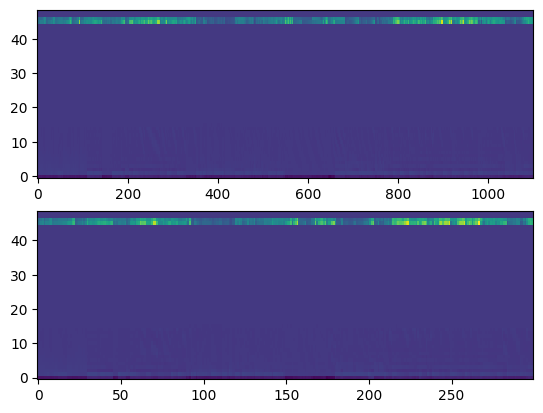

In [587]:
plt.figure(1)
plt.subplot(2,1,1)
plt.imshow(train_mfcc, interpolation='nearest', origin='lower', aspect='auto')

plt.subplot(2,1,2)
plt.imshow(valid_mfcc, interpolation='nearest', origin='lower', aspect='auto')

plt.show()



# Data Preparation

In [588]:
# load data
train_X = train_mfcc
valid_X = valid_mfcc

# label generation
cls = np.array([1,2,3,4,5,6,7,8,9,10])
train_Y = np.repeat(cls, int(NUM_TRAIN/10))
valid_Y = np.repeat(cls, int(NUM_VALID/10))

# feature normalizaiton
train_X = train_X.T
train_X_mean = np.mean(train_X, axis=0)
train_X = train_X - train_X_mean
train_X_std = np.std(train_X, axis=0)
train_X = train_X / (train_X_std + 1e-5)

valid_X = valid_X.T
valid_X = valid_X - train_X_mean
valid_X = valid_X/(train_X_std + 1e-5)


# ML Model Training & Validation

In [589]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [580]:
from sklearn.neural_network import MLPClassifier

def train_model(train_X, train_Y, valid_X, valid_Y, hyper_param1):
    # MLP 모델 정의
    clf = MLPClassifier(
        hidden_layer_sizes=(128, 64),  # 히든 레이어 구성
        activation='relu',
        solver='adam',
        alpha=hyper_param1,
        max_iter=300,
        random_state=0
    )

    clf.fit(train_X, train_Y)
    valid_Y_hat = clf.predict(valid_X)
    accuracy = np.mean(valid_Y_hat == valid_Y) * 100.0

    return clf, accuracy

In [590]:
def train_model(train_X, train_Y, valid_X, valid_Y, hyper_param1):

    clf1 = LogisticRegression(C=1.0, max_iter=1000)
    clf2 = RandomForestClassifier()
    clf3 = SVC(probability=True)  # probability=True for soft voting
    
    voting_clf = VotingClassifier(estimators=[
        # ('svd', clf),
        ('lr', clf1), ('rf', clf2), ('svc', clf3)
    ], voting='soft')
    # train
    voting_clf.fit(train_X, train_Y)

    # validation
    valid_Y_hat = voting_clf.predict(valid_X)

    accuracy = np.sum((valid_Y_hat == valid_Y))/NUM_VALID*100.0

    return voting_clf, accuracy


In [591]:
# from sklearn.neighbors import KNeighborsClassifier

# pca = PCA(n_components=30)
# train_X = pca.fit_transform(train_X)
# valid_X = pca.transform(valid_X)

# def train_model(train_X, train_Y, valid_X, valid_Y, hyper_param1):
#     # 여기서 hyper_param1은 k로 사용
#     clf = KNeighborsClassifier(n_neighbors=7)

#     clf.fit(train_X, train_Y)

#     valid_Y_hat = clf.predict(valid_X)
#     accuracy = np.mean(valid_Y_hat == valid_Y) * 100.0

#     return clf, accuracy

In [592]:
# training model
alphas = [0.0001, 0.001, 0.01, 0.1, 1]

model = []
valid_acc = []

# model search
for a in alphas:
  clf, acc = train_model(train_X, train_Y, valid_X, valid_Y, a)
  model.append(clf)
  valid_acc.append(acc)

  print(f'alpha={a:.4f}, validation acc={acc:.2f}%')

# choose the model that achieve the best validation accuracy
final_model = model[np.argmax(valid_acc)]

print(f'Best validation acc={valid_acc[np.argmax(valid_acc)]:.2f}%')


alpha=0.0001, validation acc=97.67%
alpha=0.0010, validation acc=97.67%
alpha=0.0100, validation acc=97.67%
alpha=0.1000, validation acc=97.67%
alpha=1.0000, validation acc=97.67%
Best validation acc=97.67%
